In [9]:
from collections import defaultdict
from dataclasses import dataclass
from typing import List

import cv2
import numpy as np
import math
from sklearn.cluster import DBSCAN


@dataclass
class BBox:
    x: int
    y: int
    w: int
    h: int


@dataclass
class DetectorRes:
    img: np.ndarray
    bbox: BBox


def detect(img: np.ndarray,
           kernel_size: int,
           sigma: float,
           theta: float,
           min_area: int) -> List[DetectorRes]:
    """Scale space technique for word segmentation proposed by R. Manmatha.

    For details see paper http://ciir.cs.umass.edu/pubfiles/mm-27.pdf.

    Args:
        img: A grayscale uint8 image.
        kernel_size: The size of the filter kernel, must be an odd integer.
        sigma: Standard deviation of Gaussian function used for filter kernel.
        theta: Approximated width/height ratio of words, filter function is distorted by this factor.
        min_area: Ignore word candidates smaller than specified area.

    Returns:
        List of DetectorRes instances, each containing the bounding box and the word image.
    """
    assert img.ndim == 2
    assert img.dtype == np.uint8

    # apply filter kernel
    # kernel = np.ones((25,25))
    kernel = _compute_kernel(kernel_size, sigma, theta)
    plt.imshow(kernel, cmap='gray')
    plt.show()
    img_filtered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    plt.imshow(img_filtered, cmap='gray')
    plt.show()
    img_thres = 255 - cv2.threshold(img_filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    plt.imshow(img_thres, cmap='gray')
    plt.show()

    # append components to result
    res = []
    components = cv2.findContours(img_thres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    # print(components)
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < min_area:
            continue
        # append bounding box and image of word to result list
        x, y, w, h = cv2.boundingRect(c)  # bounding box as tuple (x, y, w, h)
        crop = img[y:y + h, x:x + w]
        res.append(DetectorRes(crop, BBox(x, y, w, h)))

    return res


def _compute_kernel(kernel_size: int,
                    sigma: float,
                    theta: float) -> np.ndarray:
    """Compute anisotropic filter kernel."""

    assert kernel_size % 2  # must be odd size

    # create coordinate grid
    half_size = kernel_size // 2
    xs = ys = np.linspace(-half_size, half_size, kernel_size)
    x, y = np.meshgrid(xs, ys)

    # compute sigma values in x and y direction, where theta is roughly the average x/y ratio of words
    sigma_y = sigma
    sigma_x = sigma_y * theta

    # compute terms and combine them
    exp_term = np.exp(-x ** 2 / (2 * sigma_x) - y ** 2 / (2 * sigma_y))
    x_term = (x ** 2 - sigma_x ** 2) / (2 * math.pi * sigma_x ** 5 * sigma_y)
    y_term = (y ** 2 - sigma_y ** 2) / (2 * math.pi * sigma_y ** 5 * sigma_x)
    kernel = (x_term + y_term) * exp_term

    # normalize and return kernel
    kernel = kernel / np.sum(kernel)
    return kernel


def prepare_img(img: np.ndarray,
                height: int) -> np.ndarray:
    """Convert image to grayscale image (if needed) and resize to given height."""
    assert img.ndim in (2, 3)
    assert height > 0
    assert img.dtype == np.uint8
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h = img.shape[0]
    factor = height / h
    print(img.shape)
    return cv2.resize(img, dsize=None, fx=factor, fy=factor)


def _cluster_lines(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    # compute matrix containing Jaccard distances (which is a proper metric)
    num_bboxes = len(detections)
    print(num_bboxes)
    dist_mat = np.ones((num_bboxes, num_bboxes))
    for i in range(num_bboxes):
        for j in range(i, num_bboxes):
            a = detections[i].bbox
            b = detections[j].bbox
            if a.y > b.y + b.h or b.y > a.y + a.h:
                continue
            intersection = min(a.y + a.h, b.y + b.h) - max(a.y, b.y)
            union = a.h + b.h - intersection
            iou = np.clip(intersection / union if union > 0 else 0, 0, 1)
            dist_mat[i, j] = dist_mat[j, i] = 1 - iou  # Jaccard distance is defined as 1-iou
    print(dist_mat)

    dbscan = DBSCAN(eps=max_dist, min_samples=min_words_per_line, metric='precomputed').fit(dist_mat)
    print(dbscan.labels_)
    
    clustered = defaultdict(list)
    for i, cluster_id in enumerate(dbscan.labels_):
        if cluster_id == -1:
            continue
        clustered[cluster_id].append(detections[i])

    res = sorted(clustered.values(), key=lambda line: [det.bbox.y + det.bbox.h / 2 for det in line])
    return res


def sort_multiline(detections: List[DetectorRes],
                   max_dist: float = 0.7,
                   min_words_per_line: int = 2) -> List[List[DetectorRes]]:
    """Cluster detections into lines, then sort the lines according to x-coordinates of word centers.

    Args:
        detections: List of detections.
        max_dist: Maximum Jaccard distance (0..1) between two y-projected words to be considered as neighbors.
        min_words_per_line: If a line contains less words than specified, it is ignored.

    Returns:
        List of lines, each line itself a list of detections.
    """
    lines = _cluster_lines(detections, max_dist, min_words_per_line)
    res = []
    for line in lines:
        res += sort_line(line)
    return res


def sort_line(detections: List[DetectorRes]) -> List[List[DetectorRes]]:
    """Sort the list of detections according to x-coordinates of word centers."""
    return [sorted(detections, key=lambda det: det.bbox.x + det.bbox.w / 2)]

Processing file ./images/a01-000u.png
(1339, 2098)


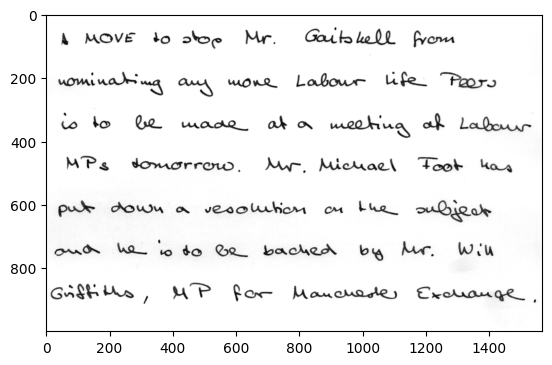

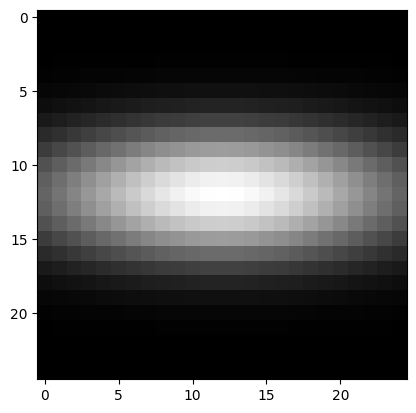

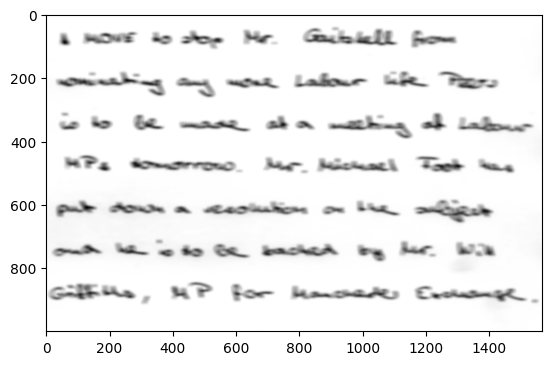

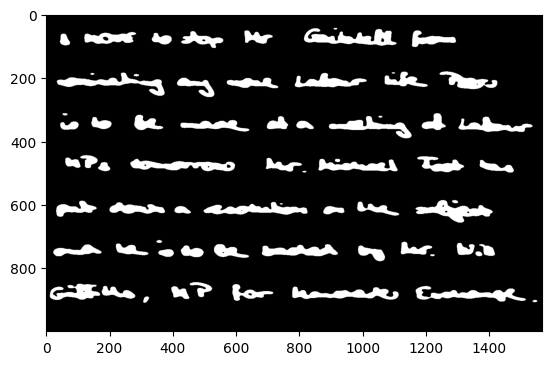

61
[[0.         0.80392157 0.84615385 ... 1.         1.         1.        ]
 [0.80392157 0.         0.07142857 ... 1.         1.         1.        ]
 [0.84615385 0.07142857 0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         0.19230769 0.18644068]
 [1.         1.         1.         ... 0.19230769 0.         0.23636364]
 [1.         1.         1.         ... 0.18644068 0.23636364 0.        ]]
[ 0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1 -1  2  2  2  2
  2  2 -1  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  5
  5  5  5  5  5  6  6  6  6  6  6  6  6]
44 62 32 37
179 71 19 14
121 57 164 37
334 59 63 37
427 54 133 53
627 52 89 42
815 45 293 55
1156 52 139 52
34 185 341 73
414 201 118 61
571 201 163 33
786 186 227 45
1070 182 136 48
1243 181 183 56
45 339 58 26
143 325 64 38
279 318 91 48
425 334 218 37
698 322 67 41
791 337 55 26
894 322 261 70
1187 313 76 53
1303 324 234 48
61 453 48 32
108 445 55 41
164 467 39

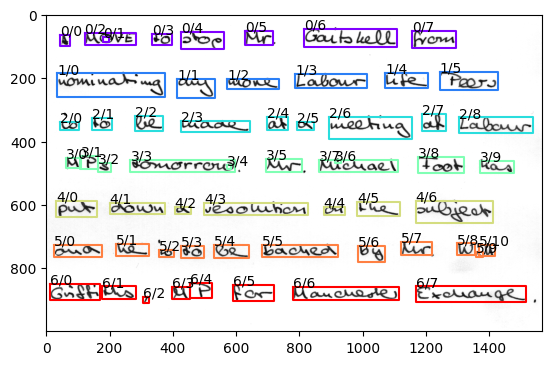

In [10]:
import os
from path import Path
import cv2
import matplotlib.pyplot as plt
from typing import List
import warnings
warnings.filterwarnings("ignore")

# Define parameters directly
data_dir = Path('./images')
kernel_size = 25
sigma = 11.0
theta = 7.0
min_area = 100
img_height = 1000
list_img_names_serial = []

def get_img_files(data_dir: Path) -> List[Path]:
    """Return all image files contained in a folder."""
    res = []
    for ext in ['*.png', '*.jpg', '*.bmp']:
        res += Path(data_dir).files(ext)
    return res

def save_image_names_to_text_files():
    for fn_img in get_img_files(data_dir):
        print(f'Processing file {fn_img}')

        # Assume prepare_img, detect, sort_multiline functions are defined elsewhere
        img = prepare_img(cv2.imread(fn_img), img_height)
        plt.imshow(img,cmap="gray")
        plt.show()
        detections = detect(img, kernel_size=kernel_size, sigma=sigma, theta=theta, min_area=min_area)
        lines = sort_multiline(detections)

        plt.imshow(img, cmap='gray')
        num_colors = 7
        colors = plt.cm.get_cmap('rainbow', num_colors)
        for line_idx, line in enumerate(lines):
            for word_idx, det in enumerate(line):
                xs = [det.bbox.x, det.bbox.x, det.bbox.x + det.bbox.w, det.bbox.x + det.bbox.w, det.bbox.x]
                ys = [det.bbox.y, det.bbox.y + det.bbox.h, det.bbox.y + det.bbox.h, det.bbox.y, det.bbox.y]
                plt.plot(xs, ys, c=colors(line_idx % num_colors))
                plt.text(det.bbox.x, det.bbox.y, f'{line_idx}/{word_idx}')
                print(det.bbox.x, det.bbox.y, det.bbox.w, det.bbox.h)
                crop_img = img[det.bbox.y:det.bbox.y + det.bbox.h, det.bbox.x:det.bbox.x+det.bbox.w]

                path = './test_images'
                if not os.path.exists(path):
                    os.mkdir(path)
                    print("Directory Created")

                cv2.imwrite(f"./test_images/line{line_idx}word{word_idx}.jpg", crop_img)
                full_img_path = f"line{line_idx}word{word_idx}.jpg"
                list_img_names_serial.append(full_img_path)

        textfile = open("img_names_sequence.txt", "w")
        for element in list_img_names_serial:
            textfile.write(element + "\n")
        textfile.close()
        plt.show()

save_image_names_to_text_files()

In [12]:
loss = [13.5317, 10.3462, 8.5526, 6.7379, 5.4714, 4.7050, 4.1794, 3.7974, 3.5319, 3.3092, 3.1153, 2.9787, 2.8510, 2.7469, 2.6548, 2.5664, 2.4979, 2.4332, 2.3804, 2.3149, 2.2846, 2.2084, 2.1841, 2.1388, 2.1087, 2.0683, 2.0313, 1.9903, 1.9646, 1.9495, 1.9097, 1.8896, 1.8610, 1.8370, 1.8180, 1.7952, 1.7845, 1.7525, 1.7413, 1.7215, 1.7154, 1.7181, 1.6842, 1.6546, 1.6516, 1.6511, 1.6204, 1.5930, 1.6013, 1.5845]
val_loss = [11.6022, 9.2906, 7.2317, 5.3968, 4.4324, 3.8659, 3.4006, 3.0727, 2.8286, 2.7150, 2.5845, 2.4428, 2.4482, 2.3229, 2.3012, 2.2444, 2.1277, 2.0997, 2.0491, 2.0014, 1.9854, 1.9554, 1.9791, 1.9576, 1.9394, 1.8593, 1.8384, 1.8356, 1.8294, 1.7958, 1.7945, 1.8291, 1.8093, 1.8118, 1.7614, 1.7769, 1.7654, 1.7462, 1.7499, 1.7128, 1.7543, 1.7517, 1.7040, 1.7493, 1.7570, 1.7402, 1.7250, 1.7593, 1.7472, 1.7194]
eval_loss = [20.4195, 20.0692, 19.6766, 18.8635, 18.3384, 18.0935, 17.9341, 17.8579, 17.7926, 17.7490, 17.6924, 17.6388, 17.6368, 17.5908, 17.6069, 17.5676, 17.4916, 17.4720, 17.4827, 17.4569, 17.4391, 17.4337, 17.4458, 17.4336, 17.4082, 17.3809, 17.3962, 17.3853, 17.3824, 17.3642, 17.3750, 17.3828, 17.3754, 17.3665, 17.3557, 17.3470, 17.3531, 17.3506, 17.3633, 17.3369, 17.3408, 17.3347, 17.3208, 17.3512, 17.3257, 17.3228, 17.3552, 17.3466, 17.3295, 17.3287]
epochs = [i for i in range(1,51)]

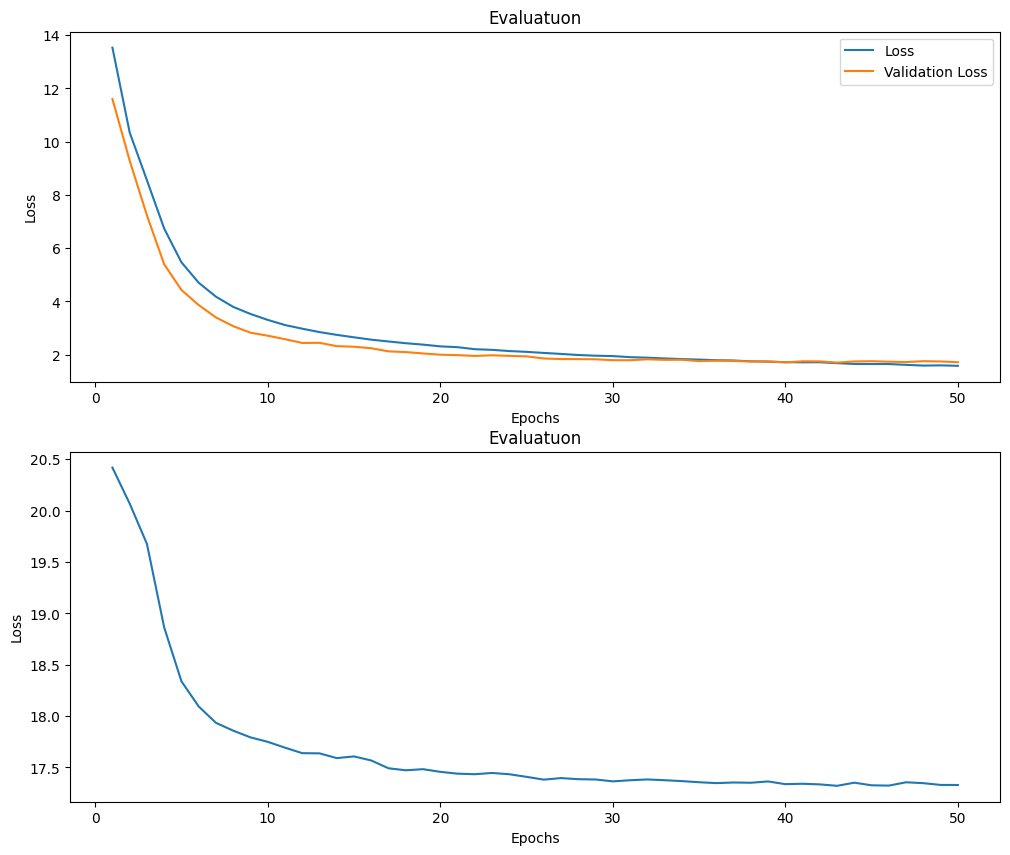

In [30]:
fig, axs = plt.subplots(2, figsize=(12, 10))
axs[0].plot(epochs, loss, label='Loss')
axs[0].plot(epochs, val_loss, label='Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, eval_loss, label='Edit CallBack Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

axs[0].set_title('Evaluatuon')
axs[1].set_title('Evaluatuon')

# Display the plot
plt.show()